**Задание**

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

###### **Библиотеки**

In [0]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import random
import warnings
from datetime import timedelta

warnings.filterwarnings('ignore')

TARGET = 'TARGET'
random.seed(26)

In [0]:
def add_first_diff(df, feature=0):
  first_diff =np.array(df.iloc[1:,feature].values - df.iloc[:-1,feature].values).astype('float32') 
  df[TARGET] = 0
  df[TARGET] = df[TARGET].astype('float') 
  df[TARGET].values[1:] = first_diff
  return df


##### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [4]:
data = pd.read_csv('/content/drive/My Drive/my_BRENT2019.csv',  parse_dates = {'Date' : [0]} )
data = data.set_index('Date')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
Значение           2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [5]:
data.head(9)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0
2010-09-06,76.87,2010,9,6,3,249,36,0,1,0,0
2010-09-07,77.26,2010,9,7,3,250,36,1,0,0,1
2010-09-08,77.93,2010,9,8,3,251,36,2,0,0,0
2010-09-09,77.21,2010,9,9,3,252,36,3,0,0,0


###### Анализ пропусков

In [6]:
full_list_date = pd.date_range(data.index.min(), data.index.max(), freq="D")
diff_list = set(full_list_date) - set(data.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')

Количество пропущенных дней: 621


In [7]:
data['date'] = data.index
count_data = data['date'].value_counts()
mask = count_data.values != 1
notvalid_days = pd.Series(count_data.values[mask], count_data.index[mask])
notvalid_days 

Series([], dtype: int64)

В выборке пропущено 621 значение, нескольких значений за одну дату нет.
Необходимо проанализировать пропуски.

Восстановим пропущенные дни.

In [8]:
full_data = pd.DataFrame(full_list_date, columns=['Date'], index=full_list_date)
full_data = full_data.join(data, on='Date', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 13 columns):
Date               3288 non-null datetime64[ns]
Значение           2667 non-null float64
year               2667 non-null float64
month              2667 non-null float64
dayofmonth         2667 non-null float64
quarter            2667 non-null float64
dayofyear          2667 non-null float64
weekofyear         2667 non-null float64
dayofweek          2667 non-null float64
is_holiday         2667 non-null float64
is_prev_holiday    2667 non-null float64
is_next_holiday    2667 non-null float64
date               2667 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(11)
memory usage: 359.6 KB


In [0]:
def prepare_features(df):
  df['is_na'] = 0
  df.loc[df['Значение'].isna(), ['is_na']] = 1
  df['weekofyear'] = df['Date'].dt.weekofyear
  df.drop(columns=['year', 'month','quarter', 'dayofmonth', 'dayofyear', 'dayofweek', 'date', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
  df.fillna(method='pad', inplace=True)
  return df

In [10]:
full_data = prepare_features(full_data)
full_data.info()
del data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 4 columns):
Date          3288 non-null datetime64[ns]
Значение      3288 non-null float64
weekofyear    3288 non-null int64
is_na         3288 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 128.4 KB


###### Добавление первых разностей

In [11]:
full_data = add_first_diff(full_data, 1)
full_data['2016-10-01 00:00:00':'2016-10-31 00:00:00']

,Date,Значение,weekofyear,is_na,TARGET
2016-10-01,2016-10-01,49.41,39,1,0.00
2016-10-02,2016-10-02,49.41,39,1,0.00
2016-10-03,2016-10-03,50.80,40,0,1.39
2016-10-04,2016-10-04,51.31,40,0,0.51
2016-10-05,2016-10-05,51.61,40,0,0.30
2016-10-06,2016-10-06,52.59,40,0,0.98
2016-10-07,2016-10-07,51.69,40,0,-0.90
2016-10-08,2016-10-08,51.69,40,1,0.00
2016-10-09,2016-10-09,51.69,40,1,0.00
2016-10-10,2016-10-10,53.52,41,0,1.83


##### 2. Добавьте первые разности по стоимости доллара и евро к рублю

In [12]:
data_euro = pd.read_excel('/content/drive/My Drive/R_E01_09_2010_T01_09_2019.xlsx',  parse_dates = {'Date' : [0]}, usecols=[1,2])
data_euro.set_index('Date', inplace=True)
data_euro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 1 columns):
curs    2228 non-null float64
dtypes: float64(1)
memory usage: 34.8 KB


In [13]:
data_euro.head()

,curs
Date,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [14]:
data_dollar = pd.read_excel('/content/drive/My Drive/RC_F01_09_2010_T01_09_2019.xlsx',  parse_dates = {'Date' : [0]}, usecols=[1,2])
data_dollar.set_index('Date', inplace=True)
data_dollar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 1 columns):
curs    2228 non-null float64
dtypes: float64(1)
memory usage: 34.8 KB


In [15]:
data_dollar.head()

,curs
Date,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


###### Анализ пропусков

In [16]:
diff_list = set(data_dollar.index.unique()) - set(full_data.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')
diff_list = set(full_data.index.unique()) - set(data_dollar.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')
diff_list = set(data_euro.index.unique()) - set(data_dollar.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')

Количество пропущенных дней: 0
Количество пропущенных дней: 1060
Количество пропущенных дней: 0


###### Заполним пропуски данными за предыдущий день и заполним первые разности

In [0]:
def fill_NA_curs(data, full_list_date):
  df = pd.DataFrame(full_list_date, columns=['Date'], index=full_list_date)
  df = df.join(data, on='Date', how='left')
  df['is_na'] = 0
  df.loc[df['curs'].isna(), ['is_na']] = 1
  df.fillna(method='pad', inplace=True)
  return df

In [18]:
data_euro = fill_NA_curs(data_euro, full_list_date)
data_euro = add_first_diff(data_euro, 1)
data_euro.rename(columns={TARGET:f'{TARGET}_euro', 'curs':'curs_euro', 'is_na':'is_na_euro'}, inplace=True)
data_euro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 4 columns):
Date           3288 non-null datetime64[ns]
curs_euro      3288 non-null float64
is_na_euro     3288 non-null int64
TARGET_euro    3288 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 128.4 KB


In [19]:
data_dollar = fill_NA_curs(data_dollar, full_list_date)
data_dollar = add_first_diff(data_dollar, 1)
data_dollar.rename(columns={TARGET:f'{TARGET}_dollar', 'curs':'curs_dollar', 'is_na':'is_na_dollar'}, inplace=True)
data_dollar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 4 columns):
Date             3288 non-null datetime64[ns]
curs_dollar      3288 non-null float64
is_na_dollar     3288 non-null int64
TARGET_dollar    3288 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 128.4 KB


##### 3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [0]:
df = full_data.resample('w').mean()
df_euro = data_euro.resample('w').mean()
df_dollar = data_dollar.resample('w').mean()
del data_dollar, data_euro

In [21]:
df = df.join(df_dollar, how='left').join(df_euro, how='left')
del df_euro, df_dollar
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 10 columns):
Значение         470 non-null float64
weekofyear       470 non-null float64
is_na            470 non-null float64
TARGET           470 non-null float64
curs_dollar      470 non-null float64
is_na_dollar     470 non-null float64
TARGET_dollar    470 non-null float64
curs_euro        470 non-null float64
is_na_euro       470 non-null float64
TARGET_euro      470 non-null float64
dtypes: float64(10)
memory usage: 60.4 KB


In [22]:
df.head()

,Значение,weekofyear,is_na,TARGET,curs_dollar,is_na_dollar,TARGET_dollar,curs_euro,is_na_euro,TARGET_euro
2010-09-05,76.616000,35.0,0.000000,0.052000,30.747440,0.200000,-0.034940,39.233840,0.200000,0.067560
2010-09-12,77.771429,36.0,0.142857,0.247143,30.793714,0.285714,0.028786,39.287000,0.285714,-0.022686
2010-09-19,78.590000,37.0,0.142857,-0.018571,30.887129,0.285714,0.026986,39.984557,0.285714,0.231400
2010-09-26,78.558571,38.0,0.142857,0.101429,31.003800,0.285714,-0.019229,41.040657,0.285714,0.064057
2010-10-03,81.582857,39.0,0.142857,0.678571,30.585086,0.285714,-0.062657,41.382686,0.285714,0.057243


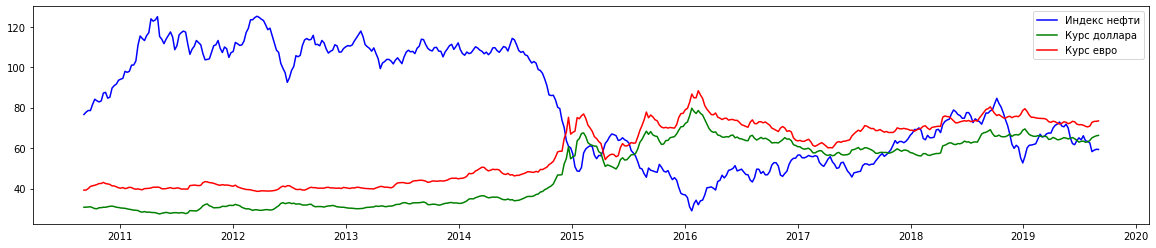

In [23]:
plt.figure(figsize =(20,4))
plt.plot(df.index, df['Значение'], 'b', label='Индекс нефти' )
plt.plot(df.index, df['curs_dollar'], 'g', label='Курс доллара' )
plt.plot(df.index, df['curs_euro'], 'r', label='Курс евро' )
plt.legend()
plt.show()

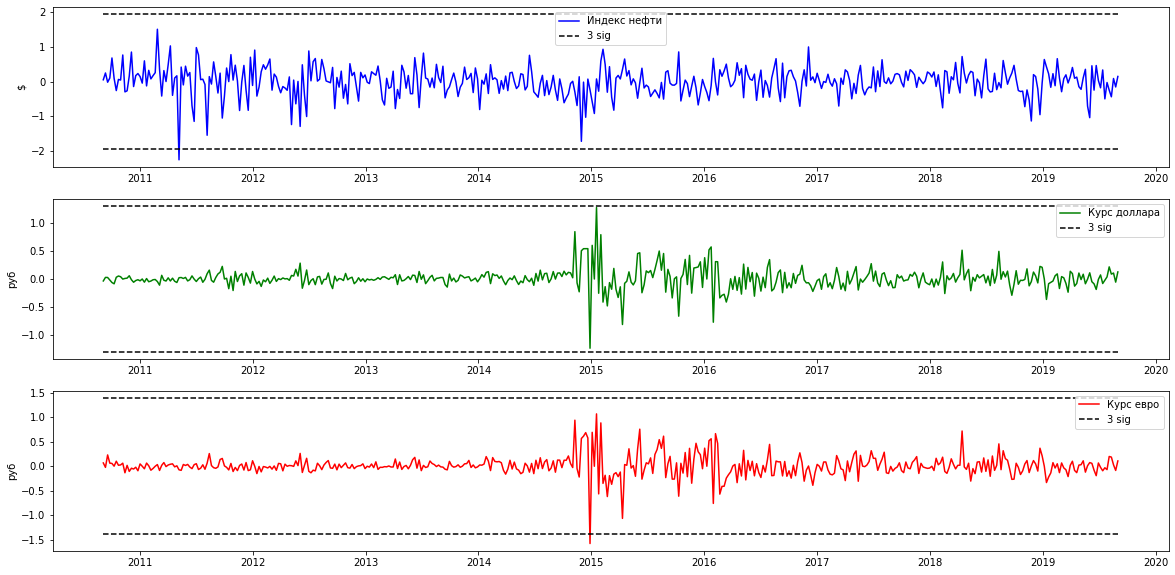

In [24]:
s_brent = np.std(df[TARGET])**0.5 *3
s_dollar = np.std(df[f'{TARGET}_dollar'])**0.5 *3
s_euro = np.std(df[f'{TARGET}_euro'])**0.5 *3

plt.figure(figsize =(20,10))
plt.subplot(3,1,1)
plt.plot(df.index, df[TARGET], 'b', label='Индекс нефти' )
plt.plot(df.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.ylabel ( '$' )
plt.legend()
plt.subplot(3,1,2)
plt.plot(df.index, df[f'{TARGET}_dollar'], 'g', label='Курс доллара' )
plt.plot(df.iloc[[0,-1]].index,[s_dollar, s_dollar],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_dollar, -s_dollar],'--k')
plt.ylabel ( 'руб' )
plt.legend()
plt.subplot(3,1,3)
plt.plot(df.index, df[f'{TARGET}_euro'], 'r', label='Курс евро' )
plt.plot(df.iloc[[0,-1]].index,[s_euro, s_euro],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_euro, -s_euro],'--k')
plt.ylabel ( 'руб' )
plt.legend()
plt.show()

##### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [0]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# сделаем примеры и модель 
def split_data( data, koeff = None, test_count = None ):
    if koeff is None and test_count is None:
      raise ValueError(f'the separator is not filled')
    elif (koeff is not None):
      last_train_date = data.index.min() + timedelta(7*int(data.shape[0]*(1-koeff)))
    else:
      last_train_date = data.index.max() - timedelta(7*test_count)

    return data.loc[data.index <= last_train_date].copy(), \
           data.loc[data.index >  last_train_date].copy(), \
           last_train_date

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def add_features(df, p, target):
  df['Date'] = df.index
  df['year'] = df['Date'].dt.year
  df['month'] = df['Date'].dt.month
  df['quarter'] = df['Date'].dt.quarter
  df.drop(columns=['Date'], axis=1,inplace=True)
  #добавляем первую разность
  first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') 
  df['diff1'] = 0
  df['diff1'] =  df['diff1'].astype('float') 
  df['diff1'].values[1:] = first_diff
  
  #добавляем логариф признака 
  first_diff_l =np.log(df.iloc[1:,0].values) 
  df['diff1_l'] = 0
  df['diff1_l'] =  df['diff1_l'].astype('float') 
  df['diff1_l'].values[1:] = first_diff_l

  df['exp_0_01'] = exponential_smoothing(df[target], 0.01)
  df['exp_0_03'] = exponential_smoothing(df[target], 0.03)
  df['exp_0_04'] = exponential_smoothing(df[target], 0.04)
  df['exp_0_06'] = exponential_smoothing(df[target], 0.06)
  df['exp_0_07'] = exponential_smoothing(df[target], 0.07)
  df['exp_0_08'] = exponential_smoothing(df[target], 0.08)
  df['d_w4']= df[target].rolling(window=4).mean()
  df['d_w6']= df[target].rolling(window=6).mean()
  df['d_w10']= df[target].rolling(window=10).mean()
  df['d_w4'].fillna(0, inplace=True)
  df['d_w10'].fillna(0, inplace=True)
  
  for i in range(p):
    df['t'+str(p-i)]=0
    df['t'+str(p-i)].values[p:] = df[target].values[i:-(p)+i]
    df['d'+str(p-i)]=0
    df['d'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]
  return df

In [26]:
df_d1 = df#.drop(columns=['Значение', 'curs_euro', 'curs_dollar'], axis=1,inplace=False)
p = 10
df_d1 = add_features(df_d1, p, TARGET)
df_d1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 44 columns):
Значение         470 non-null float64
weekofyear       470 non-null float64
is_na            470 non-null float64
TARGET           470 non-null float64
curs_dollar      470 non-null float64
is_na_dollar     470 non-null float64
TARGET_dollar    470 non-null float64
curs_euro        470 non-null float64
is_na_euro       470 non-null float64
TARGET_euro      470 non-null float64
year             470 non-null int64
month            470 non-null int64
quarter          470 non-null int64
diff1            470 non-null float64
diff1_l          470 non-null float64
exp_0_01         470 non-null float64
exp_0_03         470 non-null float64
exp_0_04         470 non-null float64
exp_0_06         470 non-null float64
exp_0_07         470 non-null float64
exp_0_08         470 non-null float64
d_w4             470 non-null float64
d_w6             465 non-null floa

In [0]:
def find_best_features(df, target_column, h,  p, count_feats=5):
    scl_target=StandardScaler()
    scl_x=StandardScaler()
    target = df[target_column].values[h+p:].reshape((df.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    

    X = df.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))

    sfk =SelectKBest(f_regression, k=count_feats)
    X_new1 = sfk.fit_transform(X, y.ravel())
    print(f'SelectKBest:{df.columns[sfk.get_support()]}')

    sfp=SelectPercentile(f_regression, percentile=20)
    X_new2 = sfp.fit_transform(X, y.ravel())
    print(f'SelectPercentile20:{df.columns[sfp.get_support()]}')
          
    gr_model = GradientBoostingRegressor(random_state=26).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = count_feats)

    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    print(f'SelectFromModel:{df.columns[sfm.get_support()]}')
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m)

In [28]:
h = 1
find_best_features(df_d1.copy(), TARGET, h, p, 10)

SelectKBest:Index(['weekofyear', 'month', 'quarter', 't10', 't9', 'd9', 't8', 't7', 't5',
       'd5'],
      dtype='object')
SelectPercentile20:Index(['weekofyear', 'month', 'quarter', 't10', 't9', 'd9', 't8', 't5', 'd5'], dtype='object')
SelectFromModel:Index(['weekofyear', 'TARGET', 'curs_dollar', 'curs_euro', 'TARGET_euro',
       'diff1', 'd_w4', 'd_w6', 'd_w10', 'd6'],
      dtype='object')
Номера признаков k лучших признаков :  [ 1 11 12 24 26 27 28 30 34 35]
Номера признаков лучших признаков по процентной форме:  [ 1 11 12 24 26 27 28 34 35]
Номера признаков для выбора по модели :  [ 1  3  4  7  9 13 21 22 23 33]


###### Построим GradientBoostingRegressor

In [0]:
FEATS = ['weekofyear', 'TARGET', 'curs_dollar', 'curs_euro', 'TARGET_euro',
       'diff1', 'd_w4', 'd_w6', 'd_w10', 'd6']

In [30]:
train, test, days_delta = split_data(df_d1[FEATS], koeff=0.3)
scl_target=StandardScaler()
scl_x=StandardScaler()
X = scl_x.fit_transform(df_d1[FEATS].iloc[p:-h,:].astype('float64'))
y = scl_target.fit_transform(df_d1[TARGET].values[h+p:].reshape((df_d1[TARGET].shape[0]-h-p,1)))
X_train_1 = X[:train.shape[0],:]
y_train_1 = y[:train.shape[0],0]
X_test_1 =  X[train.shape[0]:,:]
y_test_1 =  y[train.shape[0]:,0]
X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((330, 10), (330,), (129, 10), (129,))

In [31]:
def get_random_search(X_train, y_train):
  param_dist = {
                "n_estimators":[10, 100, 200, 500, 1000],
                "max_depth":[5,8,15,25,30,None],
                "min_samples_leaf":[1,2,5,10,15,100],
                "max_leaf_nodes": [2, 5,10]
                }
  n_iter_search = 10

  model_gr =GradientBoostingRegressor()

  random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

  random_search.fit(X_train, y_train)

  report(random_search.cv_results_)
  return random_search

random_search = get_random_search(X_train_1, y_train_1)

Model with rank: 1
Mean validation score: -0.130 (std: 0.119)
Parameters: {'n_estimators': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 5, 'max_depth': 15}

Model with rank: 2
Mean validation score: -0.142 (std: 0.080)
Parameters: {'n_estimators': 100, 'min_samples_leaf': 15, 'max_leaf_nodes': 2, 'max_depth': 8}

Model with rank: 3
Mean validation score: -0.208 (std: 0.184)
Parameters: {'n_estimators': 200, 'min_samples_leaf': 10, 'max_leaf_nodes': 2, 'max_depth': 15}



In [32]:
model1_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_['max_depth'],  n_estimators=random_search.best_params_['n_estimators'])
model1_g_best.fit( X_train_1, y_train_1 ) 
y_test_1_pred_g = model1_g_best.predict(X_test_1)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1), y_pred = scl_target.inverse_transform( y_test_1_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   230.49614782854323 %


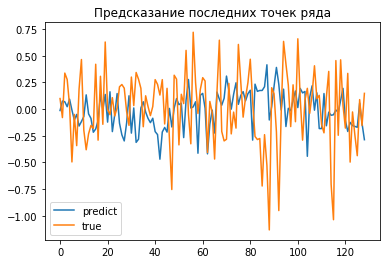

In [51]:
plt.plot(scl_target.inverse_transform( y_test_1_pred_g), label='predict' )
#Отобразим истинный значения 
plt.plot(scl_target.inverse_transform( y_test_1),label='true')
plt.title(f'Предсказание последних точек ряда')
plt.legend()

###### Построим модель линейной регрессии

In [0]:
FEATS = ['weekofyear', 'month', 'quarter', 'diff1_l', 't10', 't9', 't8', 'd6', 't5', 'd5']

In [0]:
scl_target=StandardScaler()
scl_x=StandardScaler()
X = scl_x.fit_transform(df_d1[FEATS].iloc[p:-h,:].astype('float64'))
y = scl_target.fit_transform(df_d1[TARGET].values[h+p:].reshape((df_d1[TARGET].shape[0]-h-p,1)))
X_train_1 = X[:train.shape[0],:]
y_train_1 = y[:train.shape[0],0]
X_test_1 =  X[train.shape[0]:,:]
y_test_1 =  y[train.shape[0]:,0]

In [35]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

model_lr = LR().fit(X_train_1, y_train_1)
r_sq = model_lr.score(X_train_1, y_train_1)
r_sq

0.09987589964772181

In [36]:
y_test_1_pred_lr = model_lr.predict(X_test_1)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1), y_pred = scl_target.inverse_transform( y_test_1_pred_lr))
print('ошибка линейной модели MAPE :  ', er_g,'%')

ошибка линейной модели MAPE :   123.88298819291556 %


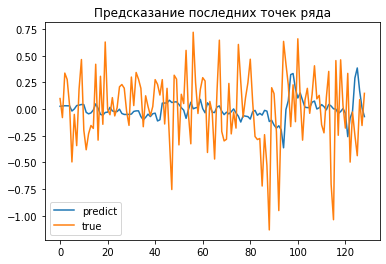

In [50]:
plt.plot(scl_target.inverse_transform(y_test_1_pred_lr), label='predict' )
#Отобразим истинный значения 
plt.plot(scl_target.inverse_transform( y_test_1),label='true')
plt.title(f'Предсказание последних точек ряда')
plt.legend()

###### Построим модель ARIMA

In [0]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

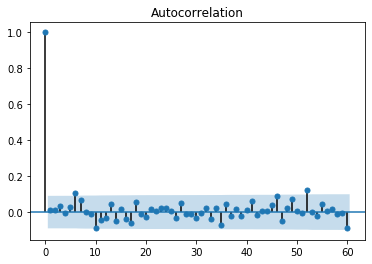

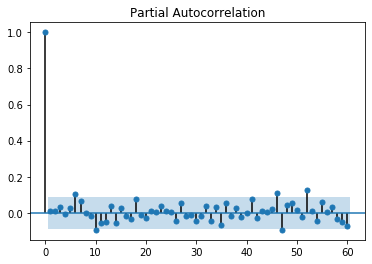

In [38]:
LAGS = 60
sm.graphics.tsa.plot_acf(df_d1[TARGET].values, lags=LAGS)
plt.show()
sm.graphics.tsa.plot_pacf(df_d1[TARGET].values, lags=LAGS)
plt.show()

In [0]:
import itertools

LAGS = 10
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], LAGS) for x in list(itertools.product(p, d, q))]

In [40]:
from tqdm import tqdm
warnings.filterwarnings('ignore')

best_aic = None
best_param = None
best_seasonal = None
best_model = None
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_d1[TARGET].values[:-test.shape[0]],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if (best_aic is None) or (best_aic > results.aic):
                best_aic = results.aic
                best_param = param
                best_seasonal = param_seasonal 
                best_model = mod
        except:
            continue
            
print('ARIMA{}x{} - AIC:{}'.format(best_param, best_seasonal, best_aic))

100%|██████████| 27/27 [21:27<00:00, 71.86s/it]

ARIMA(2, 0, 2)x(2, 0, 2, 10) - AIC:378.7802335903464


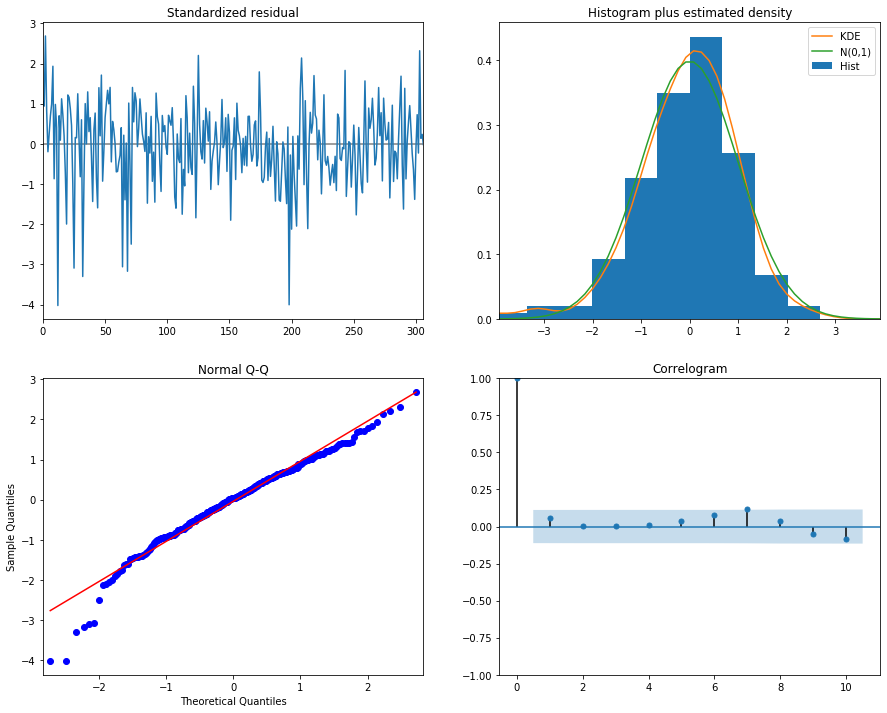

In [41]:
results = best_model.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [42]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  330
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 10)   Log Likelihood                -180.390
Date:                            Sun, 02 Feb 2020   AIC                            378.780
Time:                                    14:25:20   BIC                            412.322
Sample:                                         0   HQIC                           392.193
                                            - 330                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Исходя из графика Q-Q точки имеют сильный левый хвост, отклоняющийся от нормального распределения, вероятно, это заполнение пропусков равными значениями предыдущего дня.
Значения p_value = 0 в тесте Дика-Фуллера

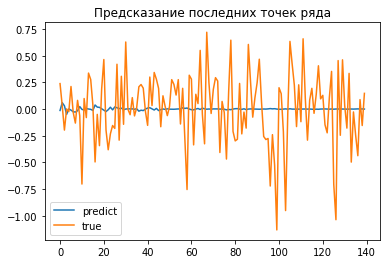

In [43]:
pred_dynamic = results.forecast(test.shape[0]) 
plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(df_d1[TARGET].values[-test.shape[0]:],label='true')
plt.title(f'Предсказание последних точек ряда')
plt.legend()

In [44]:
er_g = mean_absolute_percentage_error(y_true=df_d1[TARGET].values[-test.shape[0]:], y_pred = pred_dynamic)
print('ошибка ARIMA модели MAPE :  ', er_g,'%')

ошибка ARIMA модели MAPE :   126.47221526016608 %


In [48]:
test_ADF_1 = sm.tsa.stattools.adfuller(results.resid,regression='ctt')
test_ADF_1

(-17.362477954493,
 0.0,
 0,
 329,
 {'1%': -4.406692791737193,
  '10%': -3.564434089194019,
  '5%': -3.8504591681140776},
 383.4052045994241)

###### Построим модель ARIMA с лагом 53 недели

In [45]:
mod = sm.tsa.statespace.SARIMAX(df_d1[TARGET].values[:-53],order=[1, 1, 0],
                                    seasonal_order=[1, 1, 0, 53] ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
results_53 = mod.fit()
print(results_53.summary().tables[0],results_53.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  417
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 53)   Log Likelihood                -262.412
Date:                            Sun, 02 Feb 2020   AIC                            530.824
Time:                                    14:25:26   BIC                            542.024
Sample:                                         0   HQIC                           535.301
                                            - 417                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

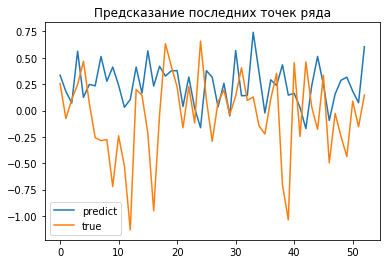

In [46]:
pred_dynamic = results_53.forecast(53) 
plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(df_d1[TARGET].values[-53:],label='true')
plt.title(f'Предсказание последних точек ряда')
plt.legend()

In [47]:
er_g = mean_absolute_percentage_error(y_true= df_d1[TARGET].values[-53:], y_pred = pred_dynamic)
print('ошибка ARIMA модели MAPE :  ', er_g,'%')

ошибка ARIMA модели MAPE :   184.7954805803906 %


In [52]:
test_ADF_2 = sm.tsa.stattools.adfuller(results_53.resid,regression='ctt')
test_ADF_2

(-8.405046856297998,
 3.4234982556748853e-11,
 16,
 400,
 {'1%': -4.400329588234375,
  '10%': -3.5624430743593747,
  '5%': -3.8472341606875},
 670.373739441656)

##### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Построить адекватную модель для предсказания 1-точки первых разностей не удалось. Линейная регрессия лучше всего описывает ряд, но лишь небольшой процент.